## Import

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


## load dataset

In [2]:
dataset = pd.read_csv('eMalahleni.csv', sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

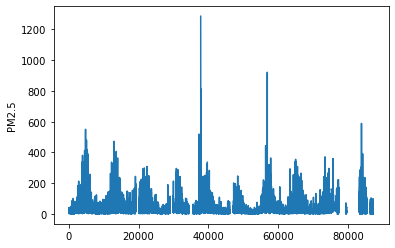

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [6]:
dataset.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'Amb Wspeed',
       'Amb WDirection', 'Temperature', 'Amb RelHum', 'Amb Pressure', 'Rain'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [7]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,]], axis=1, inplace=True)
values = reframed.values

## View the data

In [9]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.007294,0.009453,0.006847,0.009761,0.004123,0.006336,0.187196,0.000071,0.488058,0.493500,0.592229,0.837531,0.980956,0.033369,0.010048
2,0.010048,0.009666,0.026619,0.037195,0.003581,0.015276,0.164478,0.000061,0.455867,0.539833,0.553829,0.944052,0.982502,0.244162,0.014699
3,0.014699,0.014032,0.040193,0.051299,0.004753,0.020932,0.110602,0.000369,0.373832,0.403778,0.546514,0.918666,0.982652,0.160709,0.005892
4,0.005892,0.005570,0.013477,0.005693,0.002923,0.004080,0.212254,0.000337,0.505711,0.313139,0.544229,0.860627,0.980541,0.056345,0.003906
5,0.003906,0.003912,0.008607,0.011296,0.003721,0.006565,0.200885,0.000096,0.280374,0.275417,0.562971,0.794724,0.979422,0.006261,0.008862


## Create X and Y variables

In [10]:
values.shape

(36815, 15)

In [11]:
X = values[:,:-1]

In [12]:
Y = values[:,-1]

## Check the shapes

In [13]:
X.shape

(36815, 14)

In [14]:
Y.shape

(36815,)

## Reshaping

reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]

In [15]:
X = X.reshape(X.shape[0],1,X.shape[1])

In [16]:
X.shape

(36815, 1, 14)

## Training, validation and testing split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [18]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (23561, 1, 14)
Y_train: (23561,)

X_val: (5891, 1, 14)
Y_val: (5891,)

X_test: (7363, 1, 14)
Y_test: (7363,)


## Define a model

In [19]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mae', optimizer='adam')

## Print summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


## Training

In [22]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=14, verbose=1)

Epoch 1/5
1683/1683 [==============================] - 6s 4ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 2/5
1683/1683 [==============================] - 6s 4ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 3/5
1683/1683 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 4/5
1683/1683 [==============================] - 6s 3ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 5/5
1683/1683 [==============================] - 6s 4ms/step - loss: 0.0081 - val_loss: 0.0080


## Plot the performance

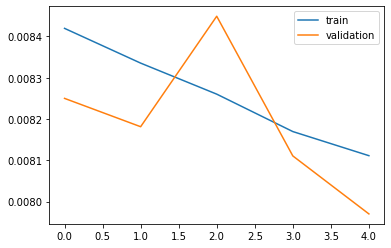

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Predict

In [24]:
prediction = model.predict(X_test)

231/231 [==============================] - 1s 1ms/step


In [25]:
mean_squared_error(Y_test, prediction)

0.0002730069

## Compare prediction and testing data

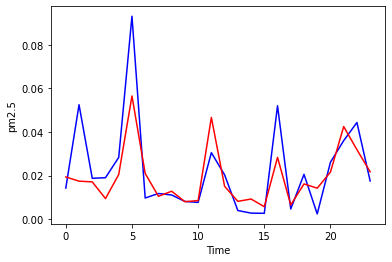

In [26]:
plt.plot(Y_test[0:24], color='blue')
plt.plot(prediction[0:24], color='red')
plt.ylabel('pm2.5')
plt.xlabel('Time')
plt.show()